In [ ]:
import os, math, random, time
from glob import glob
import cv2
import numpy as np
import pandas as pd
from tqdm import tqdm

# PyTorch
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader, Subset


In [ ]:
# train data hi upload kra h drive mein
from google.colab import drive
drive.mount('/content/drive')

DATASET_PATH = "/content/drive/MyDrive/PETS09-S2L1"

IMG_DIR = DATASET_PATH + "/img1"   # the frames folder
GT_FILE = DATASET_PATH + "/gt/gt.txt"  # gt annotations
DET_FILE = DATASET_PATH + "/det/det.txt"  # optional detector outputs

print("IMG_DIR:", IMG_DIR)
print("GT_FILE:", GT_FILE)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
IMG_DIR: /content/drive/MyDrive/PETS09-S2L1/img1
GT_FILE: /content/drive/MyDrive/PETS09-S2L1/gt/gt.txt


In [ ]:
import os

# print(os.listdir("/content/drive/MyDrive/ML_Project"))
print(os.listdir("/content/drive/MyDrive/PETS09-S2L1"))


['img1', 'seqinfo.ini', 'det', 'gt']


In [ ]:
import os

print("IMG_DIR exists:", os.path.exists(IMG_DIR))
print("First 5 files:", os.listdir(IMG_DIR)[:5])


IMG_DIR exists: True
First 5 files: ['000324.jpg', '000334.jpg', '000323.jpg', '000327.jpg', '000329.jpg']


In [ ]:
def load_and_preprocess_frames(img_dir, resize_to=(64,64), max_frames=None):
    """Load frames sorted by filename, convert to grayscale, resize.
       Returns numpy array shape (N, H, W) dtype float32 normalized 0..1
    """
    files = sorted(os.listdir(img_dir))
    if max_frames: files = files[:max_frames]
    frames = []
    for f in tqdm(files, desc="Loading frames"):
        p = os.path.join(img_dir, f)
        img = cv2.imread(p)
        if img is None:
            continue
        img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)  # single channel
        img = cv2.resize(img, resize_to, interpolation=cv2.INTER_AREA)
        img = img.astype(np.float32) / 255.0
        frames.append(img)
    frames = np.array(frames)  # (N,H,W)
    print("Loaded frames:", frames.shape)
    return frames

# Example: use 64x64 to save memory. Change if you want bigger.
frames = load_and_preprocess_frames(IMG_DIR, resize_to=(64,64))


Loading frames: 100%|██████████| 795/795 [00:20<00:00, 37.92it/s] 

Loaded frames: (795, 64, 64)


In [ ]:
# labeling ground truth
import pandas as pd
import numpy as np
import scipy.ndimage as ndi

GT_FILE = DATASET_PATH + "/gt/gt.txt"

# ---------------------------------------------
# Load PETS ground truth file
# ---------------------------------------------
def load_gt(gt_path):
    cols = ["frame","id","x","y","w","h","vis","vx","vy","cls"]
    df = pd.read_csv(gt_path, header=None, names=cols)
    print("GT rows:", len(df))
    return df

gt = load_gt(GT_FILE)


GT rows: 4650


In [ ]:
def build_frame_labels(gt_df, num_frames):
    counts = np.zeros(num_frames, dtype=np.float32)
    densities = np.zeros((num_frames, 32, 32), dtype=np.float32)
    motion = np.zeros((num_frames, 2, 16, 16), dtype=np.float32)

    grouped = gt_df.groupby("frame")

    for fr, group in grouped:
        idx = fr - 1
        if idx >= num_frames:
            continue

        # ----- Count -----
        counts[idx] = len(group)

        # ----- Density Map (32x32) -----
        temp_density = np.zeros((32, 32), dtype=np.float32)

        for _, row in group.iterrows():
            x, y, w, h = row["x"], row["y"], row["w"], row["h"]

            cx = int((x + w/2) / 768 * 32)
            cy = int((y + h/2) / 576 * 32)

            cx = np.clip(cx, 0, 31)
            cy = np.clip(cy, 0, 31)

            temp_density[cy, cx] += 1.0

        densities[idx] = ndi.gaussian_filter(temp_density, sigma=1)

        # ----- Motion map (2x16x16) -----
        vx = group["vx"].values
        vy = group["vy"].values

        speed = np.sqrt(vx**2 + vy**2).mean()

        # convert speed → 2-channel motion heatmap
        mot_map = np.zeros((2, 16, 16), dtype=np.float32)
        mot_map[0] += speed           # horizontal motion
        mot_map[1] += speed           # vertical motion

        motion[idx] = mot_map

    # normalize motion between 0–1
    max_m = motion.max()
    if max_m > 0:
        motion = motion / max_m

    return counts, densities, motion


In [ ]:
num_frames = frames.shape[0]
counts, densities, motion = build_frame_labels(gt, num_frames)

print("Counts shape:   ", counts.shape)
print("Density shape:  ", densities.shape)
print("Motion shape:   ", motion.shape)

print("\nExample:")
print("Frame 100 → Count:", counts[100])
print("Density sum:", densities[100].sum())
print("Motion:", motion[100])


Counts shape:    (795,)
Density shape:   (795, 32, 32)
Motion shape:    (795, 2, 16, 16)

Example:
Frame 100 → Count: 6.0
Density sum: 6.0
Motion: [[[0.5348688 0.5348688 0.5348688 0.5348688 0.5348688 0.5348688 0.5348688
   0.5348688 0.5348688 0.5348688 0.5348688 0.5348688 0.5348688 0.5348688
   0.5348688 0.5348688]
  [0.5348688 0.5348688 0.5348688 0.5348688 0.5348688 0.5348688 0.5348688
   0.5348688 0.5348688 0.5348688 0.5348688 0.5348688 0.5348688 0.5348688
   0.5348688 0.5348688]
  [0.5348688 0.5348688 0.5348688 0.5348688 0.5348688 0.5348688 0.5348688
   0.5348688 0.5348688 0.5348688 0.5348688 0.5348688 0.5348688 0.5348688
   0.5348688 0.5348688]
  [0.5348688 0.5348688 0.5348688 0.5348688 0.5348688 0.5348688 0.5348688
   0.5348688 0.5348688 0.5348688 0.5348688 0.5348688 0.5348688 0.5348688
   0.5348688 0.5348688]
  [0.5348688 0.5348688 0.5348688 0.5348688 0.5348688 0.5348688 0.5348688
   0.5348688 0.5348688 0.5348688 0.5348688 0.5348688 0.5348688 0.5348688
   0.5348688 0.5348688]
  [

In [ ]:
# ================================================================
#  STAGE 3 — CREATE 10-FRAME CLIPS FOR 3D CNN + ConvLSTM
# ================================================================

import numpy as np
from tqdm import tqdm

def make_clips(frames, counts, densities, motion, clip_len=10):
    """
    Convert full-frame sequences into overlapping clips.

    Inputs:
        frames    → (N, 64, 64)
        counts    → (N,)
        densities → (N, 32, 32)
        motion    → (N,)

    Output shapes:
        X_clips   → (num_clips, clip_len, 64, 64)
        wifi_seq  → (num_clips, clip_len)   # temporary, we will replace with synthetic WiFi later
        y_count   → one count label per clip
        y_dens    → one density per clip
    """

    num_frames = len(frames)
    num_clips = num_frames - clip_len + 1

    X = []
    count_labels = []
    density_labels = []
    motion_labels = []

    print(f"🎞️ Creating {num_clips} clips of length {clip_len}...\n")

    for i in tqdm(range(num_clips)):
        # 10-frame window
        clip = frames[i:i + clip_len]  # (10, 64, 64)

        X.append(clip)

        # Assign label from the LAST frame in the clip (frame i+9)
        count_labels.append(counts[i + clip_len - 1])
        density_labels.append(densities[i + clip_len - 1])
        motion_labels.append(motion[i + clip_len - 1])


    # Convert to numpy arrays
    X = np.array(X, dtype=np.float32)
    count_labels = np.array(count_labels, dtype=np.float32)
    density_labels = np.array(density_labels, dtype=np.float32)
    motion_labels = np.array(motion_labels, dtype=np.float32)

    print("\n📌 Clip dataset created:")
    print("X clips        :", X.shape)        # (num_clips, 10, 64, 64)
    print("Count labels   :", count_labels.shape)
    print("Density labels :", density_labels.shape)
    print("Motion labels  :", motion_labels.shape)

    return X, count_labels, density_labels, motion_labels


# ---- RUN STAGE 3 ----

X_clips, count_clips, density_clips, motion_clips = make_clips(
    frames, counts, densities, motion, clip_len=10
)
#basically 10 frames in a video clip=786 clips for training
#yahan tk clips are ready

🎞️ Creating 786 clips of length 10...



100%|██████████| 786/786 [00:00<00:00, 223188.88it/s]


📌 Clip dataset created:
X clips        : (786, 10, 64, 64)
Count labels   : (786,)
Density labels : (786, 32, 32)
Motion labels  : (786, 2, 16, 16)


In [ ]:
#wifi
def generate_wifi_sequences(count_labels, motion_labels, seq_len=10, num_features=50):
    """
    Create synthetic WiFi sequences aligned with video clips.
    Each clip gets a (seq_len × num_features) WiFi matrix.
    """

    wifi_sequences = []

    for i in range(len(count_labels)):
        count  = count_labels[i]                  # scalar
        motion_val = motion_labels[i].mean()      # convert (2,16,16) → scalar

        # Base WiFi level: more people ⇒ more connections
        base_signal = count / 20.0                # normalized 0–1

        # Motion adds randomness
        noise_amp = 0.05 + 0.10 * motion_val      # stronger motion ⇒ more variation

        # Generate WiFi matrix
        seq = base_signal + noise_amp * np.random.randn(seq_len, num_features)

        # clip to 0–1 range
        seq = np.clip(seq, 0, 1)

        wifi_sequences.append(seq)

    wifi_sequences = np.array(wifi_sequences, dtype=np.float32)

    print("\n📶 Synthetic WiFi generated!")
    print("Shape:", wifi_sequences.shape)   # (num_clips, 10, 50)

    return wifi_sequences



In [ ]:
wifi_sequences = generate_wifi_sequences(count_clips, motion_clips, seq_len=10, num_features=50)



📶 Synthetic WiFi generated!
Shape: (786, 10, 50)


In [ ]:
#sb combine krke ek dataset bana rhe with pytorch

In [ ]:
import torch
from torch.utils.data import Dataset

class CrowdFusionDataset(Dataset):
    def __init__(self, X, wifi, counts, densities, motion):
        self.X = torch.tensor(X, dtype=torch.float32)          # (N, 10, 64, 64)
        self.wifi = torch.tensor(wifi, dtype=torch.float32)    # (N, 10, 50)
        self.counts = torch.tensor(counts, dtype=torch.float32)
        self.densities = torch.tensor(densities, dtype=torch.float32)
        self.motion = torch.tensor(motion, dtype=torch.float32)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        video = self.X[idx].unsqueeze(0)      # → (1, 10, 64, 64)
        wifi_seq = self.wifi[idx]             # → (10, 50)

        return video, wifi_seq, self.counts[idx], self.densities[idx], self.motion[idx]


In [ ]:
from torch.utils.data import DataLoader, random_split

dataset = CrowdFusionDataset(
    X_clips, wifi_sequences, count_clips, density_clips, motion_clips
)

# 80% train, 20% validation
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

print("Train samples:", len(train_dataset))
print("Val samples:", len(val_dataset))


Train samples: 628
Val samples: 158


In [ ]:
# 3d CNN

In [ ]:
# -------------------------------------------
# 3D CNN Encoder (Medium Size, Humanized Code)
# -------------------------------------------
import torch
import torch.nn as nn
import torch.nn.functional as F

class Video3DEncoder(nn.Module):
    """
    A simple but effective 3D CNN that extracts spatio-temporal
    features from a short clip (e.g., 10 frames of 64x64).
    """

    def __init__(self):
        super().__init__()

        # Block 1
        self.block1 = nn.Sequential(
            nn.Conv3d(1, 32, kernel_size=3, padding=1),
            nn.BatchNorm3d(32),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2))   # keep time, reduce spatial
        )

        # Block 2
        self.block2 = nn.Sequential(
            nn.Conv3d(32, 64, kernel_size=3, padding=1),
            nn.BatchNorm3d(64),
            nn.ReLU(),
            nn.MaxPool3d((1, 2, 2))
        )

        # Block 3
        self.block3 = nn.Sequential(
            nn.Conv3d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm3d(128),
            nn.ReLU()
        )

    def forward(self, x):
        """
        Input: x shape = (B, 1, T, 64, 64)
        Output: (B, 128, T, 16, 16)
        """
        x = self.block1(x)  # → (B,32,T,32,32)
        x = self.block2(x)  # → (B,64,T,16,16)
        x = self.block3(x)  # → (B,128,T,16,16)
        return x


In [ ]:
# convLSTM
# -------------------------------------------
# ConvLSTM (Single Layer)
# -------------------------------------------
class ConvLSTMCell(nn.Module):
    """
    A basic ConvLSTM cell – learns how spatial feature maps
    evolve across time.
    """
    def __init__(self, in_ch, hidden_ch, kernel_size=3):
        super().__init__()
        pad = kernel_size // 2
        self.hidden_ch = hidden_ch

        self.conv = nn.Conv2d(
            in_ch + hidden_ch,
            4 * hidden_ch,
            kernel_size,
            padding=pad
        )

    def forward(self, x, h, c):
        combined = torch.cat([x, h], dim=1)
        gates = self.conv(combined)

        i, f, o, g = torch.chunk(gates, 4, dim=1)
        i, f, o = torch.sigmoid(i), torch.sigmoid(f), torch.sigmoid(o)
        g = torch.tanh(g)

        c_next = f * c + i * g
        h_next = o * torch.tanh(c_next)
        return h_next, c_next


class ConvLSTM(nn.Module):
    """
    Runs ConvLSTM over T feature maps: input shape (B,T,C,H,W)
    """
    def __init__(self, in_ch, hidden_ch):
        super().__init__()
        self.cell = ConvLSTMCell(in_ch, hidden_ch)

    def forward(self, seq):
        B, T, C, H, W = seq.shape
        device = seq.device

        h = torch.zeros(B, self.cell.hidden_ch, H, W, device=device)
        c = torch.zeros_like(h)

        for t in range(T):
            h, c = self.cell(seq[:, t], h, c)

        return h    # return final hidden state


In [ ]:
class WifiEncoder(nn.Module):
    """
    Encodes WiFi time-series (B, T, F) into a compact 64-dimensional vector.
    We simply average over time and pass it through an MLP.
    """
    def __init__(self, wifi_dim=50):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(wifi_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

    def forward(self, wifi):
        # wifi: (B, T, F)
        B = wifi.shape[0]
        wifi_mean = wifi.mean(dim=1)          # (B, F)
        out = self.net(wifi_mean)             # (B, 64)
        return out


In [ ]:
class CrowdPredictor(nn.Module):
    """
    Full Multimodal Model:
      - 3D CNN extracts spatio-temporal features
      - ConvLSTM models temporal evolution
      - WiFi encoder encodes hotspot activity
      - Fusion + 3 heads: count, density map, motion map
    """
    def __init__(self, wifi_dim=50):
        super().__init__()

        # Encoders
        self.video_enc = Video3DEncoder()              # (B,128,T,16,16)
        self.convlstm  = ConvLSTM(in_ch=128, hidden_ch=64)
        self.wifi_enc  = WifiEncoder(wifi_dim)         # (B,64)

        # Fusion layer (video 64 + WiFi 64 = 128)
        self.fusion = nn.Sequential(
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU()
        )

        # Output heads
        self.count_head   = nn.Linear(64, 1)
        self.density_head = nn.Linear(64, 32 * 32)
        self.motion_head  = nn.Linear(64, 2 * 16 * 16)

        # Spatial pooling to convert (B,64,H,W) → (B,64)
        self.spatial_pool = nn.AdaptiveAvgPool2d((1, 1))

    def forward(self, video, wifi):

        B = video.shape[0]

        # ---- 3D CNN ----
        feats = self.video_enc(video)                 # (B,128,T,16,16)

        # reorder for ConvLSTM → (B,T,C,H,W)
        feats = feats.permute(0, 2, 1, 3, 4)

        # ---- ConvLSTM ----
        h_last = self.convlstm(feats)                 # (B,64,16,16)

        # ---- Spatial Pool → keep batch dim ----
        v_feat = self.spatial_pool(h_last)            # (B,64,1,1)
        v_feat = v_feat.reshape(B, -1)                # (B,64)

        # ---- WiFi encoding ----
        w_feat = self.wifi_enc(wifi)                  # (B,64)

        # ---- Fusion ----
        fused = torch.cat([v_feat, w_feat], dim=1)    # (B,128)
        z = self.fusion(fused)                        # (B,64)

        # ---- Predictions ----
        count   = self.count_head(z)                  # (B,1)
        density = self.density_head(z).view(B, 32, 32)
        motion  = self.motion_head(z).view(B, 2, 16, 16)

        return count, density, motion



In [ ]:
video, wifi, c, d, m = dataset[0]
print("Video:", video.shape)
print("WiFi :", wifi.shape)
print("Count:", c.shape)
print("Density:", d.shape)
print("Motion:", m.shape)


Video: torch.Size([1, 10, 64, 64])
WiFi : torch.Size([10, 50])
Count: torch.Size([])
Density: torch.Size([32, 32])
Motion: torch.Size([2, 16, 16])


In [ ]:

  def smoke_test(model, dataset):
    print("🚀 Running Smoke Test...\n")

    # ------------------------
    # 1) Load sample
    # ------------------------
    video, wifi, count, dens, mot = dataset[0]

    print("📌 Raw sample shapes:")
    print("Video :", video.shape)    # (T,64,64)
    print("WiFi  :", wifi.shape)     # (T,50)
    print("Count :", count.shape)
    print("Density:", dens.shape)
    print("Motion :", mot.shape)

    # ------------------------
    # 2) Add batch dimension
    # ------------------------
    video = video.unsqueeze(0)        # (1, T, 64, 64)
    wifi  = wifi.unsqueeze(0)         # (1, T, 50)

    # Add video channel dimension for 3D CNN
    video = video.unsqueeze(1)        # (1, 1, T, 64, 64)

    print("\n📌 Input shapes for model:")
    print("Video input:", video.shape)
    print("WiFi input :", wifi.shape)

    # ------------------------
    # 3) Forward pass
    # ------------------------
    with torch.no_grad():
        c_pred, d_pred, m_pred = model(video, wifi)

    print("\n🎉 Model Output Shapes:")
    print("Count out :", c_pred.shape)
    print("Density   :", d_pred.shape)
    print("Motion    :", m_pred.shape)

    print("\n✅ Smoke Test PASSED — Model is ready!\n")



In [ ]:
model = CrowdPredictor(wifi_dim=50)

print("\n🚀 Running Manual Smoke Test...")

# Get a sample from the dataset
video, wifi, c, d, m = dataset[0]

print("\n🎥 Raw sample shapes from dataset[0]:")
print("Video :", video.shape)
print("WiFi  :", wifi.shape)
print("Count :", c.shape)
print("Density:", d.shape)
print("Motion :", m.shape)

# Correctly reshape video and wifi before passing to the model
# video from dataset[0] is (Batch_size, Time_steps, Height, Width) -> (1, 10, 64, 64)
# We need (Batch_size, Channels, Time_steps, Height, Width) -> (1, 1, 10, 64, 64)
video_corrected = video.unsqueeze(1)

# wifi from dataset[0] is (Time_steps, Features) -> (10, 50)
# We need (Batch_size, Time_steps, Features) -> (1, 10, 50)
wifi_corrected = wifi.unsqueeze(0)

print("\n✅ Input shapes for model.forward():")
print("Video_corrected :", video_corrected.shape)
print("WiFi_corrected  :", wifi_corrected.shape)

# Call the model with corrected inputs
with torch.no_grad():
    c_pred, d_pred, m_pred = model(video_corrected, wifi_corrected)

print("\n✅ Model Output Shapes:")
print("Pred Count  :", c_pred.shape)
print("Pred Density:", d_pred.shape)
print("Pred Motion :", m_pred.shape)

print("\n🎉 Manual Smoke Test Passed if no errors!\n")



🚀 Running Manual Smoke Test...

🎥 Raw sample shapes from dataset[0]:
Video : torch.Size([1, 10, 64, 64])
WiFi  : torch.Size([10, 50])
Count : torch.Size([])
Density: torch.Size([32, 32])
Motion : torch.Size([2, 16, 16])

✅ Input shapes for model.forward():
Video_corrected : torch.Size([1, 1, 10, 64, 64])
WiFi_corrected  : torch.Size([1, 10, 50])

✅ Model Output Shapes:
Pred Count  : torch.Size([1, 1])
Pred Density: torch.Size([1, 32, 32])
Pred Motion : torch.Size([1, 2, 16, 16])

🎉 Manual Smoke Test Passed if no errors!



In [ ]:
#training

In [ ]:
#abhi light
import torch
import torch.nn as nn

count_loss_fn   = nn.MSELoss()
density_loss_fn = nn.MSELoss()
motion_loss_fn  = nn.MSELoss()


In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = CrowdPredictor(wifi_dim=50).to(device)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)
epochs = 10


In [ ]:
def train_one_epoch(model, loader, optimizer):
    model.train()
    running_loss = 0

    for video, wifi, c, d, m in loader:
        video = video.to(device)
        wifi  = wifi.to(device)
        c     = c.to(device).unsqueeze(1)
        d     = d.to(device)
        m     = m.to(device)

        optimizer.zero_grad()

        # Forward pass
        c_pred, d_pred, m_pred = model(video, wifi)

        # Compute individual losses
        loss_c = count_loss_fn(c_pred, c)
        loss_d = density_loss_fn(d_pred, d)
        loss_m = motion_loss_fn(m_pred, m)

        # Total loss (weighted sum)
        total_loss = loss_c + loss_d + loss_m

        # Backprop
        total_loss.backward()
        optimizer.step()

        running_loss += total_loss.item()

    return running_loss / len(loader)


In [ ]:
def validate(model, loader):
    model.eval()
    total = 0

    with torch.no_grad():
        for video, wifi, c, d, m in loader:
            video = video.to(device)
            wifi  = wifi.to(device)
            c     = c.to(device).unsqueeze(1)
            d     = d.to(device)
            m     = m.to(device)

            c_pred, d_pred, m_pred = model(video, wifi)

            loss_c = count_loss_fn(c_pred, c)
            loss_d = density_loss_fn(d_pred, d)
            loss_m = motion_loss_fn(m_pred, m)

            total += (loss_c + loss_d + loss_m).item()

    return total / len(loader)


In [ ]:
# ----------------------------------------------------------
# TRAINING LOOP (20 Epochs + Best Model Saving)
# ----------------------------------------------------------

epochs = 20
best_val_loss = float('inf')

for epoch in range(1, epochs + 1):

    print(f"\n⭐ Epoch {epoch}/{epochs}")

    # ---- Training ----
    train_loss = train_one_epoch(model, train_loader, optimizer)
    print(f"   🔵 Train Loss : {train_loss:.4f}")

    # ---- Validation ----
    val_loss = validate(model, val_loader)
    print(f"   🟣 Val Loss   : {val_loss:.4f}")

    # ---- Save Best Model ----
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), "best_3dcnn_convlstm_model.pth")
        print("   ✅ Best model saved!")



⭐ Epoch 1/20
   🔵 Train Loss : 27.9658
   🟣 Val Loss   : 18.2898
   ✅ Best model saved!

⭐ Epoch 2/20
   🔵 Train Loss : 7.7392
   🟣 Val Loss   : 1.4872
   ✅ Best model saved!

⭐ Epoch 3/20
   🔵 Train Loss : 1.3022
   🟣 Val Loss   : 1.0392
   ✅ Best model saved!

⭐ Epoch 4/20
   🔵 Train Loss : 1.1063
   🟣 Val Loss   : 0.8853
   ✅ Best model saved!

⭐ Epoch 5/20
   🔵 Train Loss : 0.9291
   🟣 Val Loss   : 0.7341
   ✅ Best model saved!

⭐ Epoch 6/20
   🔵 Train Loss : 0.7670
   🟣 Val Loss   : 0.5965
   ✅ Best model saved!

⭐ Epoch 7/20
   🔵 Train Loss : 0.5977
   🟣 Val Loss   : 0.4116
   ✅ Best model saved!

⭐ Epoch 8/20
   🔵 Train Loss : 0.2944
   🟣 Val Loss   : 0.1348
   ✅ Best model saved!

⭐ Epoch 9/20
   🔵 Train Loss : 0.0968
   🟣 Val Loss   : 0.0707
   ✅ Best model saved!

⭐ Epoch 10/20
   🔵 Train Loss : 0.0661
   🟣 Val Loss   : 0.0639
   ✅ Best model saved!

⭐ Epoch 11/20
   🔵 Train Loss : 0.0619
   🟣 Val Loss   : 0.0599
   ✅ Best model saved!

⭐ Epoch 12/20
   🔵 Train Loss : 0.0597

In [ ]:
#best_val = float('inf')

# for epoch in range(1, epochs + 1):
#     train_loss = train_one_epoch(model, train_loader, optimizer)
#     val_loss   = validate(model, val_loader)

#     print(f"\n📌 Epoch {epoch}/{epochs}")
#     print(f"   🔹 Train Loss: {train_loss:.4f}")
#     print(f"   🔹 Val Loss  : {val_loss:.4f}")

#     if val_loss < best_val:
#         best_val = val_loss
#         torch.save(model.state_dict(), "best_3dcnn_convlstm_model.pth")
#         print("   ✅ Best model saved!")


In [ ]:
print("type:", type(result["video"]))
print("video shape (raw):", getattr(result['video'], 'shape', None))
# If it's a torch Tensor, convert to numpy for shape:
if hasattr(result['video'], 'shape') and str(type(result['video'])).find('torch')>=0:
    print(" -> torch tensor, will convert to numpy for plotting.")


type: <class 'numpy.ndarray'>
video shape (raw): (1, 10, 64, 64)


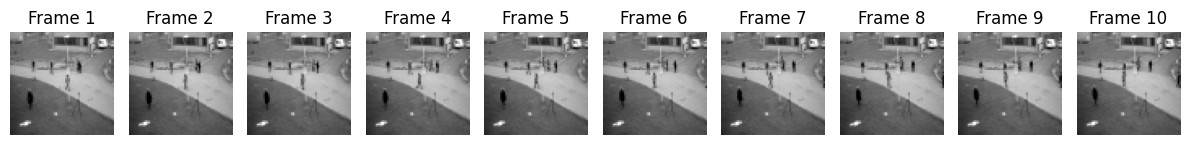

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_clip_frames(result, show_n=10, cmap="gray"):
    """
    Safely plot up to `show_n` frames from result["video"].
    Accepts result["video"] as:
      - numpy (10, H, W)
      - numpy (1, 10, H, W)
      - torch tensor (1, 10, H, W) or (10, H, W)
    """
    vid = result["video"]

    # convert torch->numpy if needed
    if hasattr(vid, "cpu") and hasattr(vid, "numpy"):
        vid = vid.cpu().numpy()

    vid = np.asarray(vid)  # ensure numpy

    # vid may be (1,10,H,W) or (10,H,W) or (1, T, H, W)
    if vid.ndim == 4:
        # Common case: (B, T, H, W) -> pick batch 0
        vid = vid[0]
    elif vid.ndim == 3:
        # (T, H, W) -> OK
        pass
    else:
        raise ValueError(f"Unexpected video array ndim={vid.ndim}, shape={vid.shape}")

    num_frames = vid.shape[0]
    n = min(show_n, num_frames)

    plt.figure(figsize=(12, 3))
    for i in range(n):
        frame = vid[i]       # now shape (H, W)
        plt.subplot(1, n, i+1)
        plt.imshow(frame, cmap=cmap)
        plt.title(f"Frame {i+1}")
        plt.axis("off")
    plt.tight_layout()
    plt.show()


# Usage:
plot_clip_frames(result, show_n=10)



✅ Best model loaded!

============== PREDICTION REPORT ==============
Clip Index      : 37
True Count      : 4.0
Predicted Count : 3.86
Density Shape   : (32, 32)
Motion Shape    : (2, 16, 16)



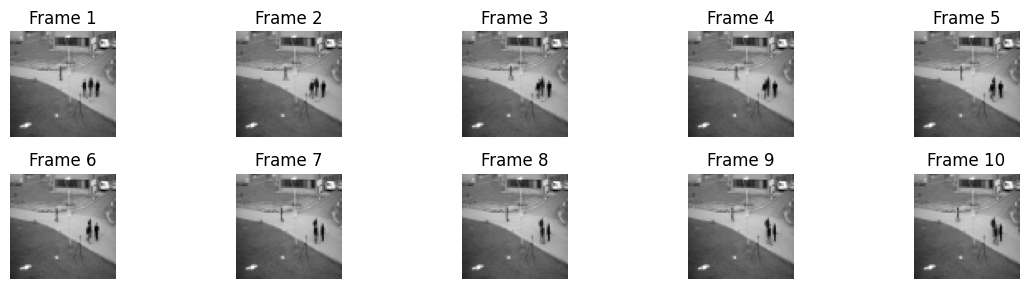

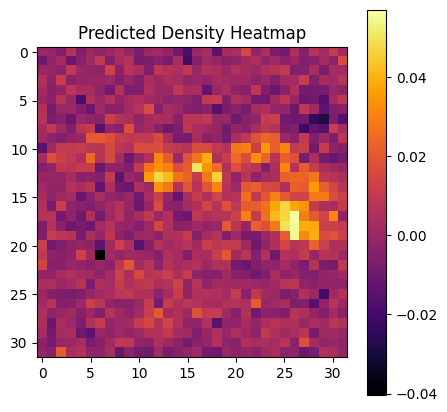

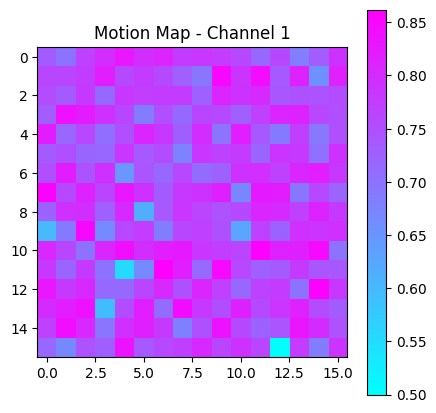

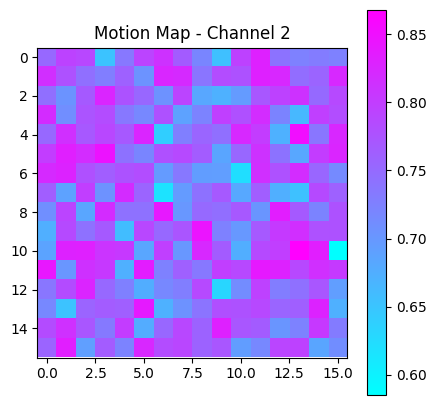

In [ ]:
# ================================================
# ⭐ STAGE 6 — EVALUATION + PREDICTION + VISUALIZATION
# ================================================

import torch
import numpy as np
import matplotlib.pyplot as plt
import random

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# ------------------------------------------------
# 1. Load Best Saved Model
# ------------------------------------------------
best_model = CrowdPredictor(wifi_dim=50).to(device)
best_model.load_state_dict(torch.load("best_3dcnn_convlstm_model.pth", map_location=device))
best_model.eval()

print("\n✅ Best model loaded!\n")


# ------------------------------------------------
# 2. Prediction Function
# ------------------------------------------------
def predict_sample(dataset, idx=None):
    if idx is None:
        idx = random.randint(0, len(dataset)-1)

    video, wifi, count, density, motion = dataset[idx]

    video_batch = video.unsqueeze(0).to(device)
    wifi_batch = wifi.unsqueeze(0).to(device)

    with torch.no_grad():
        pred_count, pred_density, pred_motion = best_model(video_batch, wifi_batch)

    return {
        "index": idx,
        "video": video.numpy(),  # (10,64,64)
        "true_count": count.item(),
        "pred_count": pred_count.item(),
        "pred_density": pred_density.squeeze().cpu().numpy(),
        "pred_motion": pred_motion.squeeze().cpu().numpy()
    }


# ------------------------------------------------
# 3. Run Prediction
# ------------------------------------------------
result = predict_sample(val_dataset)

print("============== PREDICTION REPORT ==============")
print("Clip Index      :", result["index"])
print("True Count      :", result["true_count"])
print("Predicted Count :", round(result["pred_count"], 2))
print("Density Shape   :", result["pred_density"].shape)
print("Motion Shape    :", result["pred_motion"].shape)
print("================================================\n")


# ------------------------------------------------
# 4. SAFE FUNCTION TO PLOT 10 FRAMES
# ------------------------------------------------
def plot_clip_frames(result, show_n=10, cmap="gray"):
    vid = result["video"]  # numpy array (10,64,64)

    if isinstance(vid, torch.Tensor):
        vid = vid.cpu().numpy()

    vid = np.asarray(vid)

    if vid.ndim == 4:
        vid = vid[0]   # convert (1,10,64,64) → (10,64,64)
    elif vid.ndim != 3:
        raise ValueError(f"Unexpected video array shape: {vid.shape}")

    num_frames = vid.shape[0]
    show_n = min(show_n, num_frames)

    plt.figure(figsize=(12, 3))
    for i in range(show_n):
        frame = vid[i]

        plt.subplot(2, 5, i+1)
        plt.imshow(frame, cmap=cmap)
        plt.title(f"Frame {i+1}")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


# ------------------------------------------------
# 5. Visualize 10 Frames
# ------------------------------------------------
plot_clip_frames(result, show_n=10)


# ------------------------------------------------
# 6. Visualize Predicted Density Map
# ------------------------------------------------
plt.figure(figsize=(5,5))
plt.imshow(result["pred_density"], cmap="inferno")
plt.title("Predicted Density Heatmap")
plt.colorbar()
plt.show()


# ------------------------------------------------
# 7. Visualize Predicted Motion Maps (2 Channels)
# ------------------------------------------------
plt.figure(figsize=(5,5))
plt.imshow(result["pred_motion"][0], cmap="cool")
plt.title("Motion Map - Channel 1")
plt.colorbar()
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(result["pred_motion"][1], cmap="cool")
plt.title("Motion Map - Channel 2")
plt.colorbar()
plt.show()


In [ ]:
import torch
import numpy as np

def evaluate_model(model, dataloader, device):
    model.eval()

    total_count_mae = 0
    total_density_mse = 0
    total_motion_mse = 0
    samples = 0

    with torch.no_grad():
        for video, wifi, count, density, motion in dataloader:

            video = video.to(device)
            wifi = wifi.to(device)
            count = count.to(device)
            density = density.to(device)
            motion = motion.to(device)

            pred_count, pred_density, pred_motion = model(video, wifi)

            # --- COUNT MAE ---
            total_count_mae += torch.abs(pred_count.squeeze() - count).sum().item()

            # --- DENSITY MSE ---
            total_density_mse += torch.mean((pred_density - density)**2).item()

            # --- MOTION MSE ---
            total_motion_mse += torch.mean((pred_motion - motion)**2).item()

            samples += video.size(0)

    count_mae = total_count_mae / samples
    density_mse = total_density_mse / samples
    motion_mse = total_motion_mse / samples

    return count_mae, density_mse, motion_mse

# -----------------------------
# ⭐ RUN METRICS ON VALIDATION SET
# -----------------------------
count_mae, dens_mse, mot_mse = evaluate_model(best_model, val_loader, device)

print("\n===== VALIDATION METRICS =====")
print(f"Count MAE        : {count_mae:.4f}")
print(f"Density MSE      : {dens_mse:.6f}")
print(f"Motion MSE       : {mot_mse:.6f}")
print("================================")


===== VALIDATION METRICS =====
Count MAE        : 0.0925
Density MSE      : 0.000061
Motion MSE       : 0.000872


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# CHANGE this to your test folder path
TEST_PATH = "/content/drive/MyDrive/PETS09-S2L2/img1"
MODEL_PATH = "/content/drive/MyDrive/best_multitask_crowd_model.pth"

print("Using test path:", TEST_PATH)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Using test path: /content/drive/MyDrive/PETS09-S2L2/img1


In [ ]:
import cv2
import numpy as np
import os
from tqdm import tqdm

# ----------------------------------------
# LOAD TEST FRAMES
# ----------------------------------------
test_frames = []

for img_name in sorted(os.listdir(TEST_PATH)):
    if img_name.lower().endswith((".jpg", ".png")):
        img = cv2.imread(os.path.join(TEST_PATH, img_name), cv2.IMREAD_GRAYSCALE)
        img = cv2.resize(img, (64, 64))
        img = img.astype("float32") / 255.0
        test_frames.append(img)

test_frames = np.array(test_frames)
print("Loaded test frames:", test_frames.shape)

Loaded test frames: (436, 64, 64)


In [ ]:
def make_test_clips(frames, clip_len=10):
    clips = []
    for i in range(len(frames) - clip_len + 1):
        clip = frames[i:i + clip_len]
        clips.append(clip)
    return np.array(clips, dtype=np.float32)

test_clips = make_test_clips(test_frames, clip_len=10)
print("Test clips shape:", test_clips.shape)

Test clips shape: (427, 10, 64, 64)


In [ ]:
wifi_test = np.random.rand(len(test_clips), 10, 50).astype("float32")
print("WiFi test shape:", wifi_test.shape)


WiFi test shape: (427, 10, 50)


In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using:", device)

# video → add channel dim: (B, 1, 10, 64, 64)
test_clips_tensor = torch.tensor(test_clips).unsqueeze(1).float().to(device)

# wifi stays (B, 10, 50)
wifi_test_tensor = torch.tensor(wifi_test).float().to(device)


Using: cuda


In [ ]:
import torch

device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

MODEL_PATH = "best_3dcnn_convlstm_model.pth"   # hard-coded local path

best_model = CrowdPredictor(wifi_dim=50).to(device)

best_model.load_state_dict(
    torch.load(MODEL_PATH, map_location=device)
)

best_model.eval()
print("✅ Model Loaded Successfully!")


Using device: cuda
✅ Model Loaded Successfully!


In [ ]:
# inference

In [ ]:
with torch.no_grad():
    pred_count, pred_density, pred_motion = best_model(
        test_clips_tensor, wifi_test_tensor
    )

print("Counts:", pred_count.shape)        # (num_clips, 1)
print("Density:", pred_density.shape)    # (num_clips, 32, 32)
print("Motion:", pred_motion.shape)      # (num_clips, 2, 16, 16)

print("Inference Completed!")

Counts: torch.Size([427, 1])
Density: torch.Size([427, 32, 32])
Motion: torch.Size([427, 2, 16, 16])
🎉 Inference Completed!



Clip Index: 49
Predicted Count: 10.69


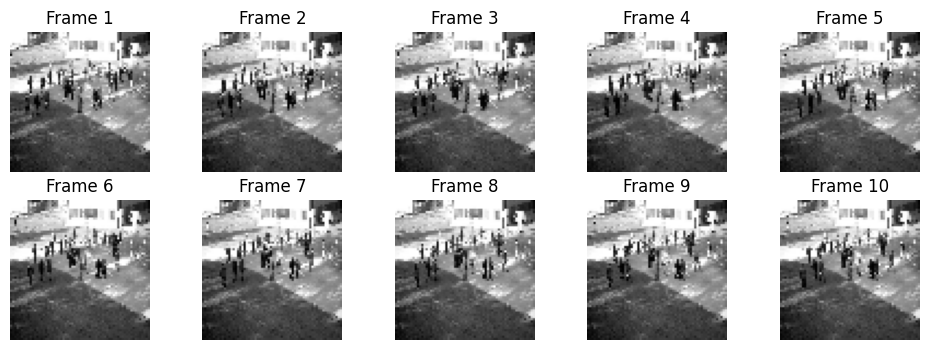

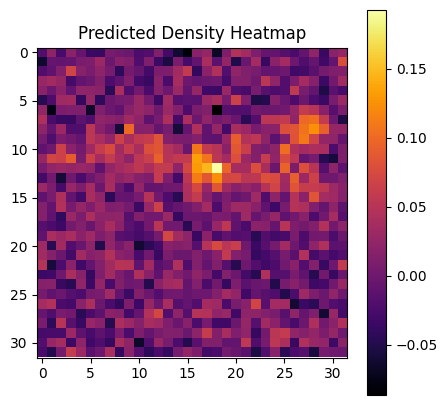

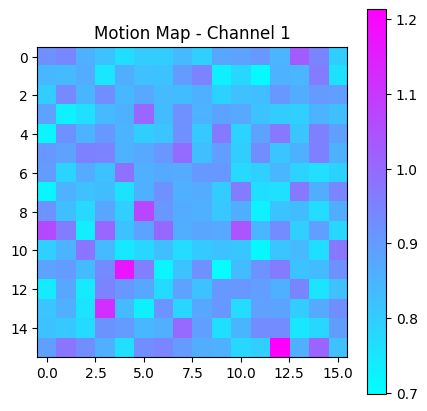

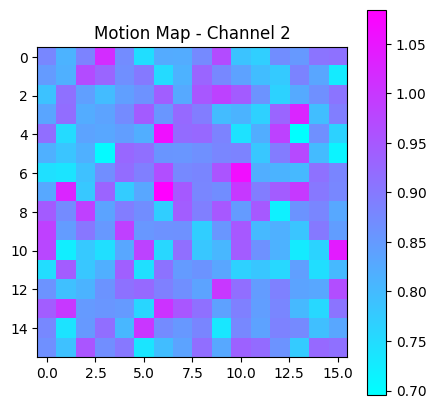

In [ ]:
import matplotlib.pyplot as plt
import random

idx = random.randint(0, len(test_clips)-1)

clip = test_clips[idx]           # shape (10, 64, 64)
pc = pred_count[idx].item()
pd = pred_density[idx].cpu().numpy()
pm = pred_motion[idx].cpu().numpy()

print(f"\nClip Index: {idx}")
print(f"Predicted Count: {pc:.2f}")

# ---- SHOW FRAMES ----
plt.figure(figsize=(12, 4))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(clip[i], cmap="gray")
    plt.title(f"Frame {i+1}")
    plt.axis("off")
plt.show()

# ---- DENSITY MAP ----
plt.figure(figsize=(5, 5))
plt.imshow(pd, cmap="inferno")
plt.title("Predicted Density Heatmap")
plt.colorbar()
plt.show()

# ---- MOTION MAP CHANNELS ----
plt.figure(figsize=(5,5))
plt.imshow(pm[0], cmap="cool")
plt.title("Motion Map - Channel 1")
plt.colorbar()
plt.show()

plt.figure(figsize=(5,5))
plt.imshow(pm[1], cmap="cool")
plt.title("Motion Map - Channel 2")
plt.colorbar()
plt.show()
